In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
cd /content/drive/'My Drive'/Code/Tracking

/content/drive/My Drive/Code/Tracking


In [3]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7MB 78kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
!pip install motmetrics

  Using cached motmetrics-1.2.0-py3-none-any.whl (151 kB)
     |████████████████████████████████| 72 kB 202 kB/s eta 0:00:011
  Using cached mccabe-0.6.1-py2.py3-none-any.whl (8.6 kB)
     |████████████████████████████████| 41 kB 37 kB/s s eta 0:00:01
     |████████████████████████████████| 66 kB 917 kB/s eta 0:00:011
     |████████████████████████████████| 280 kB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 1.1 MB/s  eta 0:00:01
     |████████████████████████████████| 49 kB 921 kB/s  eta 0:00:01
     |████████████████████████████████| 95 kB 421 kB/s  eta 0:00:01
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-py3-none-any.whl size=20070 sha256=6dabc55450fba7dff0ff33181c2b9a880583b59c17f71aa22eef4b829266f948
  Stored in directory: /home/franel/.cache/pip/wheels/b4/99/9f/8eb77fdf759c1380719071722f2c37dd0fa1f6aa477c51cb6c
Successfully built py-cpuinfo


In [1]:
from __future__ import division, print_function, absolute_import
import cv2 as cv
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
sys.path
sys.path.append('./yolo')
from DetectorYolo3 import DetectorYolo3_CPU

from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet

# For evaluation
import motmetrics as mm
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
# importation du fichier de vérité terrain
annotation = pd.read_csv('videos/gt/gt.txt', sep=',', 
                         names=['frame_number', 'identity_id', 'left', 'top', 'width', 'height', 'score', 'x', 'y', 'z'])
annotation.head()

,frame_number,identity_id,left,top,width,height,score,x,y,z
0,1,9,499,158,31.030,75.170,1,-4.1554,-7.3591,0
1,1,15,258,219,32.913,88.702,1,-11.3060,-5.5995,0
2,1,19,633,242,42.338,81.074,1,-9.0323,-12.5870,0
3,2,9,497,158,31.030,75.170,1,-4.1744,-7.3156,0
4,2,15,263,218,32.774,88.505,1,-11.2100,-5.6516,0


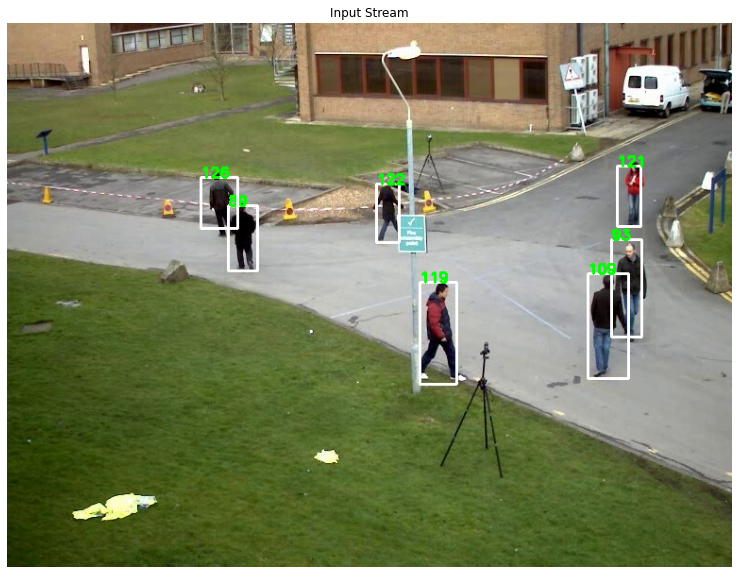

In [7]:
vin="./videos/PETS09-S2L1-raw.mp4"  

## Create a detector
configPath = "./yolo/yolov3-tiny.cfg"
weightPath = "./yolo/yolov3-tiny.weights"
metaPath = "./yolo/coco.data"
classPath="./yolo/coco.names" 
confThr=0.25
nmsThr=0.6
detector=DetectorYolo3_CPU(configPath,weightPath,classPath)

## Create a tracker (deep_sort )
max_cosine_distance = 0.3
nn_budget = None
nms_max_overlap = 1.0
model_filename = 'mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
tracker = Tracker(metric)

# Create a video cap
cap = cv.VideoCapture(vin)
frameW=int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frameH=int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

count=0

# Create an accumulator that will be updated during each frame
acc = mm.MOTAccumulator(auto_id=True)

# annotation file
annotation = pd.read_csv('videos/gt/gt.txt', sep=',', 
                         names=['frame_number', 'identity_id', 'left', 'top', 'width', 'height', 'score',
                                'x', 'y', 'z'])
while True:
    ret, frame = cap.read()
    if ret != True:
        break;
    count +=1
    if count%2==1:
        boxs=detector.predict(frame,'person',0.25,0.4,32,64)
        for b in boxs:
            b[2]=b[2]-b[0]
            b[3]=b[3]-b[1]
        features = encoder(frame,boxs)
    
        # score to 1.0 here).
        detections = [Detection(bbox, 1.0, feature) for bbox, feature in zip(boxs, features)]

        # Run non-maxima suppression.
        boxes = np.array([d.tlwh for d in detections])
        scores = np.array([d.confidence for d in detections])
        indices = preprocessing.non_max_suppression(boxes, nms_max_overlap, scores)
        detections = [detections[i] for i in indices]

        # Call the tracker
        tracker.predict()
        tracker.update(detections)
        
        ################################################# Update informations results about each frame
        if len(tracker.tracks) > 0:
            # Get person list of this frame
            annot = annotation.loc[(annotation['frame_number']==count) & (annotation['score'] == 1),:]
            objects_list = annot['identity_id'].values.tolist() # Person list in this frame
            a = np.array([
                [i[2], i[3], i[4], i[5]] for i in annot.values   # Format X, Y, Width, Height
            ])

            b = []
            person_pypothesis = 0
            detector_hypotheses = []
            for track in tracker.tracks:
                if not track.is_confirmed() or track.time_since_update > 1:
                    continue
                bbox = track.to_tlbr()
                b.append([int(bbox[0]), int(bbox[1]), int(bbox[2]) - int(bbox[0]), int(bbox[3]) - int(bbox[1])]) # Format X, Y, Width, Height
                detector_hypotheses.append(track.track_id)   #get person hypothesis (detected) in this frame
                person_pypothesis += 1
            
            b = np.array(b)
            
            # Call update once for per frame. For now, assume distances between
            # frame objects / hypotheses are given.
            acc.update(
                objects_list,                                   # Ground truth objects in this frame
                detector_hypotheses,                            # Detector hypotheses in this frame
                mm.distances.iou_matrix(a, b, max_iou=0.5)      # Distances from object i to hypotheses j
            )
        ################################################ End
    
        ##### Show track result
        for track in tracker.tracks:
            if not track.is_confirmed() or track.time_since_update > 1:
                continue
            bbox = track.to_tlbr()
            cv.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255,255,255), 2)
            cv.putText(frame, str(track.track_id),(int(bbox[0]), int(bbox[1])),0, 5e-3 * 100, (0,255,0),2)

        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        clear_output(wait=True)
        plt.figure(figsize=(15,10))
        plt.axis('off')
        plt.title("Input Stream")
        plt.imshow(frame)
        plt.show()
cap.release()

In [5]:
# Affichage des résultats

mh = mm.metrics.create()
summary = mh.compute(acc, metrics=mm.metrics.motchallenge_metrics, name='acc')

strsummary = mm.io.render_summary(
    summary,
    formatters=mh.formatters,
    namemap=mm.io.motchallenge_metric_names
)

print(strsummary)

     IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML  FP  FN IDs   FM  MOTA  MOTP IDt IDa IDm
acc 51.4% 53.0% 49.9% 79.6% 84.4% 19 11  8  0 657 915  65  199 63.4% 0.289  37  16   3
